<a href="https://colab.research.google.com/github/sommoMicc/DeepLearning-Homeworks/blob/master/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW5: Autoencoders**

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version of it. Next, we will experiment with the application of a denoising autoencoder. Finally, we will experiment with sequential domains, considering the IMDB dataset, alredy used in HW4.

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
Each value is between 0 and 255, and represents a pixel in an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, we will split the test set, in the test and validation set.

In [0]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW we will focus our attention on SVD decomposition. Indeed it is more numerical stable. Given a matrix X, the SVD decomposes a matrix into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T$$

SVD is implemented in NumPy as np.linalg.svd. In our case the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that the X matrix, in our case, will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore, to optimize the memory consumption we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we can relate the decomposition of the covariance matrix $C= X^T \cdot X$ to the decomposition of $X$. In fact

$$ C= X^T \cdot X = U \cdot S \cdot V^T \cdot V\cdot S \cdot U^T  = U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the Colab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [0]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data, and compute the compressed version of the training set and the test set.

**To complete: What happens varying the ENCODING_DIM? test  and discuss the results in this cell**

**Discussion:** I've tested some values of ENCODING_DIM. The lowest I tried was just one, which corresponds to taking the most important principal component of the decomposition. The reconstructed input consisted in the same image  repeated. We can see that the image is well centered, with a black background and a white (but blurried) object in the center (which looks like a 8 or a 9) ![alt text](https://drive.google.com/uc?export=download&id=1ODLrIzH9BIZuGfq5aT9ULFaV7Te7j1Mq)
This means that, according to PCA, the most meaningful information is that the number itself is white and well centered on the image, while the background is black.

With an increase in the number of features from 1 to 7, I started to have a significative distinction among the numbers, as we can see from the following image:
![alt text](https://drive.google.com/uc?export=download&id=1KNsWEVSXu-wrymxLqmxpYJPQc5IFsmqY)
Some numbers, like 7, 1, 0 and 9 looks distingushable, while the others not yet. But, in my opinion, this is quite impressive, because I'm using only 7 dimensions (instead of 784), which is less than 1/100 of the initial size. 

Using 50 dimensions, the reconstructed images looks a bit blurried but the number are very distinguishable, as we can see from the image below: 
![alt text](https://drive.google.com/uc?export=download&id=1nMfjjHrOENVvb6-RSJv7U1ozJljlHBnY)

With the original value of 120 dimensions, images looks even more detailed:
![](https://drive.google.com/uc?export=download&id=1AfNI4JoatAHNogpzQoUupfHRJXg7SdYL).

The last value I tried was 240 dimensions:
![](https://drive.google.com/uc?export=download&id=16n2m-LihYb0S3fk5-Di8KvxB0wk8txb6). Looking the images very closely, we can see that, with respect of 120 dimensions, the level of detail is higher. However, the gain in detail is quite low in my opinion, considering also that the number of dimensions (so the size of the representation) is doubled. 

This fact however is endemic of PCA, because first principal components capture the most significative informations of the data.

In [0]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)

Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images

In [0]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)




In [0]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [0]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed, by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images shows input data, while the second one shows the reconstructions.

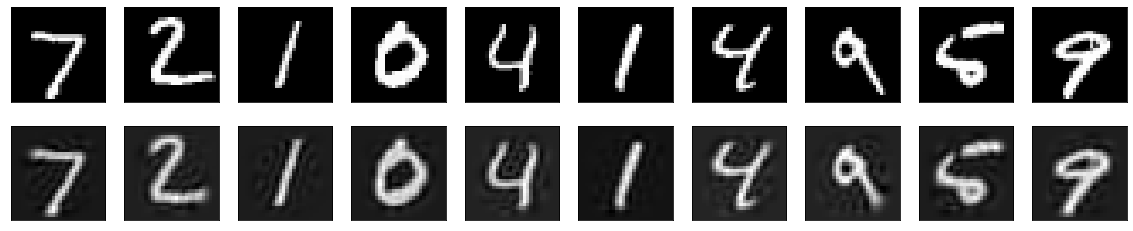

In [0]:
plot_img(10, x_test, x_test_reco)

## Exercise 5.1: Shallow Linear Autoencoder
Let's define the model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various parts of the model (encoder and decoder) separately and create the final model. 

**To complete: check the results and compare them with the results obtained by SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.**


In [0]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [0]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [0]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0419 - val_loss: 0.0144
Epoch 2/15
98/98 [==============================] - 2s 15ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 3/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 2s 15ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 5/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 6/15
98/98 [==============================] - 2s 15ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 7/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 9/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 10/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 11/

Plot the loss and the accuracy curves, and the accuracy on the test set.

In [0]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0056
test mse: 0.00561


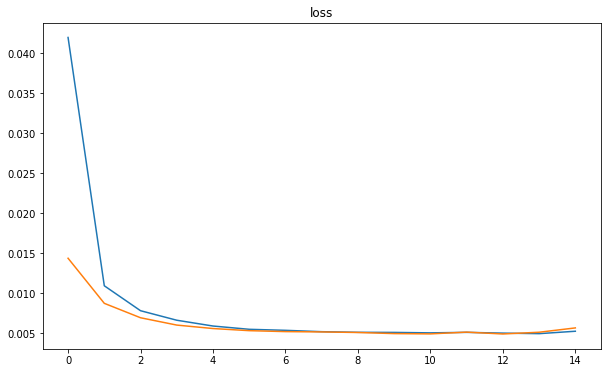

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

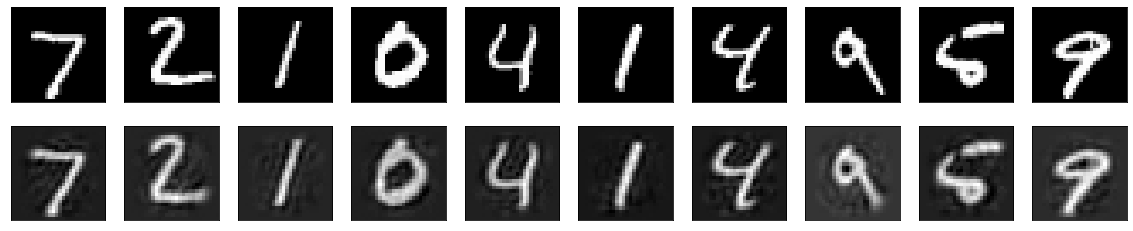

In [0]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


**Discussion**:
Here below I reported the two different results obtained from PCA (SVD) and _Shallow linear autoencoders_ on the same test set and using the same number of dimensions (120).

_PCA_ (test mse: 0.00455)
![PCA](https://drive.google.com/uc?export=download&id=1AfNI4JoatAHNogpzQoUupfHRJXg7SdYL)
_shallow linear autoencoders_ (test mse: 0.00476)
![Shallow linear autoencoders](https://drive.google.com/uc?export=download&id=1w9lR3TS6Hd4yVf585VW4UJuX5HKVlXVd)

From the images it's evident that the obtained results are very similar, and also the Mean Squared Errors computed on the test set have more or less the same value. This is because PCA and Shallow Linear Autoencoders are strictly related. In fact, given a feed forward neural network with only one hidden layer and a linear activation function $\sigma(x) = x$, the output $o$ is computed as following:
$$
o = W_o \cdot W_i \cdot x
$$
where $x$ is the input, $W_i$ are the weights of the input->hidden connection and $W_o$ the hidden->output ones. Since $o = x$, we derive that $x = W_o \cdot W_i \cdot x$, so it must be that $W_i = W_o^T$.
Also, since the encoding of the input is the output of the hidden layer, it becomes:
$enc(x) = W_i \cdot x$, and the reconstructed input $\hat{x} = W_o \cdot enc(x) = W_i^T \cdot enc(x)$.


The PCA decomposition computes the encoded representation of the input as $enc(x) = U \cdot x$ and the reconstructed version of the input as $\hat{x} = U^T enc(x)$. 

Now, if we set $W_i = U$, we have that the two methods described are equivalent, in the sense that do essentially the same ting.

##Exercise  5.2: Shallow non-linear autoencoders

**To complete: replicate the code of exercise 5.1 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1.**


In [0]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [0]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0553 - val_loss: 0.0357
Epoch 2/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0286 - val_loss: 0.0227
Epoch 3/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0194 - val_loss: 0.0164
Epoch 4/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0147 - val_loss: 0.0129
Epoch 5/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0118 - val_loss: 0.0106
Epoch 6/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0099 - val_loss: 0.0091
Epoch 7/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 8/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 9/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 10/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 11/

313/313 - 0s - loss: 0.0041
test mse: 0.00415


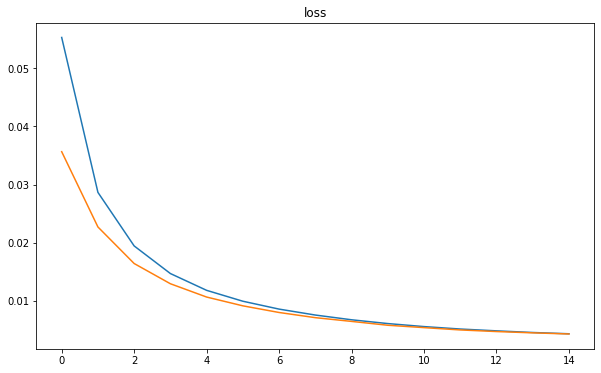

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

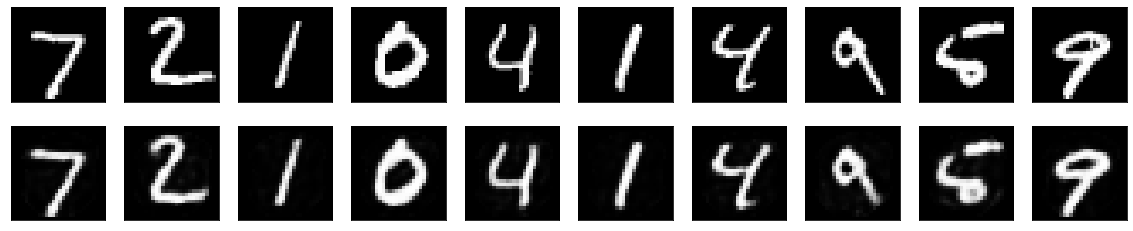

In [0]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

The obtained results are reported in the two images below:

_shallow linear autoencoders_ (test mse: 0.00479)
![Shallow linear autoencoders](https://drive.google.com/uc?export=download&id=1w9lR3TS6Hd4yVf585VW4UJuX5HKVlXVd)

_shallow non linear autoencoders_ (test mse: 0.00428)
![alt text](https://drive.google.com/uc?export=download&id=197pPyKGIrvCDwvlkq7-x747vOgZTQ75n)

As we can see, altough the test Mean Squared Errors are similar, the non linear autoencoder provides a better representation of the input, in the sense that decoded images look more detailed (less blurred). This is because, using a non linear activation function, the nonlinear autoencoder can model a more complex space, which is (maybe) closer to the manifold of the input data.

Regarding the activation function, I tried various options: _tanh_, _sigmoid_, _ReLu_. In the end, I choose _sigmoid_ because that gave me the better result: the other two tend to overfit more and to give more blurred images.

## Exercise 5.3: Deep Autoencoder
**To_complete: Define a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (e.g., 748->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e, 128->748, the resulting structure recall an hourglass).
Similarly than what did above, print the model summary, the loss curve during the training, the achieved loss on the test set, and some input image with the correspondent decoding.**


In [0]:
input_img = tf.keras.layers.Input(shape=(784,))
deep_epochs_number = 250

deep_nonlinear_encoder_activations = ['sigmoid','selu', 'selu', 'selu']
deep_nonlinear_decoder_activations = ['selu','selu','selu','sigmoid']


def deep_autoencoder(steps, input_img, encoder_activations, decoder_activations):
  img_size = steps[0]
  encoders = []

  prev_layer = input_img

  for i in range(1,len(steps)):
    step = steps[i]
    act = encoder_activations[(i-1) % len(encoder_activations)]
    print("Encoder #%d: (%d, act: %s)" % (i-1, step, act))
    encoders.append(tf.keras.layers.Dense(step, activation=act)(prev_layer))
    prev_layer = encoders[-1]
  
  decoders = []
  
  steps.reverse()
  steps.pop(0)  # Remove the size of the final representation

  print("---")
  for i in range(len(steps)):
    step = steps[i]
    act = decoder_activations[i % len(encoder_activations)]

    print("Decoder #%d: (%d, act: %s)" % (i, step, act))

    decoders.append(tf.keras.layers.Dense(step, activation=act)(prev_layer))
    prev_layer = decoders[-1]

  autoencoder = tf.keras.models.Model(input_img, decoders[-1])
  return autoencoder




autoencoder = deep_autoencoder(
    [784,512,256,120,60],
    input_img,
    deep_nonlinear_encoder_activations,
    deep_nonlinear_decoder_activations
    )
autoencoder.compile(optimizer='adam', loss='mse')

Encoder #0: (512, act: sigmoid)
Encoder #1: (256, act: selu)
Encoder #2: (120, act: selu)
Encoder #3: (60, act: selu)
---
Decoder #0: (120, act: selu)
Decoder #1: (256, act: selu)
Decoder #2: (512, act: selu)
Decoder #3: (784, act: sigmoid)


In [0]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_7 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_8 (Dense)              (None, 120)               7320      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               3097

In [0]:
history = autoencoder.fit(x_train, x_train, epochs=deep_epochs_number, batch_size=512, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/250
98/98 [==============================] - 7s 75ms/step - loss: 0.0626 - val_loss: 0.0386
Epoch 2/250
98/98 [==============================] - 7s 72ms/step - loss: 0.0320 - val_loss: 0.0267
Epoch 3/250
98/98 [==============================] - 7s 72ms/step - loss: 0.0233 - val_loss: 0.0200
Epoch 4/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0184 - val_loss: 0.0166
Epoch 5/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 6/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 7/250
98/98 [==============================] - 7s 74ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 8/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 9/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 10/250
98/98 [==============================] - 7s 74ms/step - loss: 0.0093 - val_loss: 0.0090

313/313 - 1s - loss: 0.0029
test mse: 0.00288


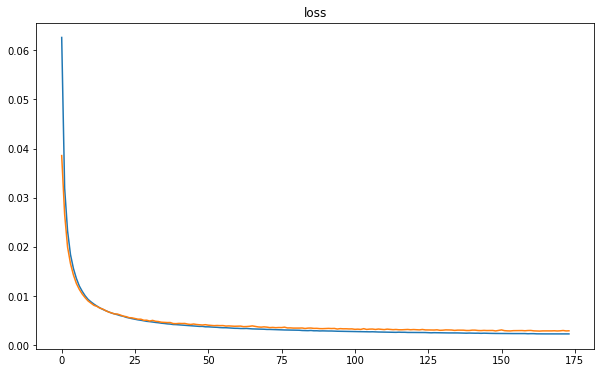

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

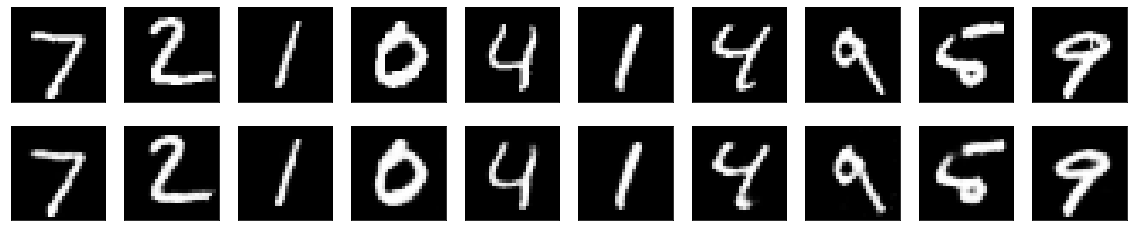

In [0]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


**Brief discussion**
This deep autoencoder has seven hidden layers: four of them are the encoding part, the remaining three are the decoding part. The activation function I chose are Sigmoid, SeLU, SeLU, SeLU for the encoding part and the same (but in reverse order) for the decoding one. I made this choice after having tried combination of Sigmoid, Tahn and SeLU and I saw that, when using the Tanh function instead of Sigmoid or SeLU or both, I obtained more blurred images, although the test Mean Squared Error was similar.

Also, I noticed that doubling the batch size gave me a performance increment, bringing the loss from about 0.004 to 0.00278

In my opinion, the most rilevant part of this autoencoder is the size of the representation. In fact the final test MSE is 0.00278, which is like half of  the Shallow nonlinear one, but also the size of the representation is halved (only 60 parameters instead of 120). 


## Exercise 5.4: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data, and to check how much it influences the denoising capability of the autoencoder.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

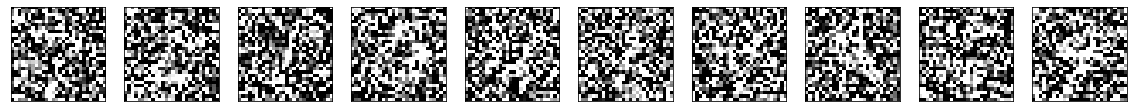

In [0]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**To_complete: use the same model defined in the exercise 5.3.**

In [0]:
input_img = tf.keras.layers.Input(shape=(784,))

autoencoder = deep_autoencoder(
    [784,512,256,120,60],
    input_img,
    deep_nonlinear_encoder_activations,
    deep_nonlinear_decoder_activations
    )
autoencoder.compile(optimizer='adam', loss='mse')


Encoder #0: (512, act: sigmoid)
Encoder #1: (256, act: selu)
Encoder #2: (120, act: selu)
Encoder #3: (60, act: selu)
---
Decoder #0: (120, act: selu)
Decoder #1: (256, act: selu)
Decoder #2: (512, act: selu)
Decoder #3: (784, act: sigmoid)


In [0]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 120)               30840     
_________________________________________________________________
dense_15 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_16 (Dense)             (None, 120)               7320      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               3097

**To complete: Train the model by passing the noisy input and the clean target.**

In [0]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=deep_epochs_number, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)], batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0743 - val_loss: 0.0663
Epoch 2/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0662 - val_loss: 0.0597
Epoch 3/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0545 - val_loss: 0.0491
Epoch 4/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0473 - val_loss: 0.0453
Epoch 5/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0438 - val_loss: 0.0420
Epoch 6/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0418 - val_loss: 0.0407
Epoch 7/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0402 - val_loss: 0.0396
Epoch 8/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0388 - val_loss: 0.0388
Epoch 9/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0378 - val_loss: 0.0377
Epoch 10/250
98/98 [==============================] - 7s 73ms/step - loss: 0.0369 - val_loss: 0.0369

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

Check the result by plotting some input images and the correspondent denoised outputs

In [0]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

**Brief discussion**
Since I was forced to use the structure of the previous model, there is not much I could optimized for this task. However, I have to say that it's quite impressive how it manages to reconstruct, sometimes very well and sometimes less, the input which, at least to my eyes, looks totally unreadable. 

About the model, I noticed that it tends to overfit a lot more in this denoising task.

## Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [0]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by the IMDB dataset loader, we use the to_categorical method to transform them in the correspondent one-hot representations.

In [0]:
from keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in exercise 5.1, while the encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense layer on each time step of the sequence. 

Since the output will be a one-hot representation, let's use the binary_crossentropy as loss and the CategoricalAccuracy as metric.

In [0]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

In [0]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Let's plot the accuracy and the loss curves and check the reconstruction capability of the model by plotting the reconstruction of a test sample.

In [0]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [0]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

##Exercise 5.5: Non-Linear Autoencoder for sequences

**To complete: Replicate the code of the exercise above, but instead of using a simpleRNN with linear activations do use non-linear activation functions and a LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.**

**Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.**


In [0]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, activation='sigmoid', return_sequences=True)(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

In [0]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=100, batch_size=256, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

In [0]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [0]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

Softmax as activation of the last layer because it is a classification problem. 

I also doubled the batch size (now it's 256) and doubled the number of epochs, since I saw that with 50 epochs the loss was still decrementing near the end. 

In regards of the comparison with the linear one, this model performs better BUT it is also more complex. In fact, since I used the same number of neurons as the linear model, but these are LSTM, the number of parameter of the nonlinear model is more or less tripled.
